# c_multi view cascade(MVC)

## seed값 17 설정, lambda = 0.1

## 0. 공통 설정

In [1]:
import os
import json
import time
import psutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import AutoModel, TrainingArguments, Trainer
from safetensors.torch import load_file
from scipy.stats import spearmanr


## 1. MultiViewCascadeModel 정의

In [2]:
class MultiViewCascadeModel(nn.Module):
    def __init__(self, encoder_name, num_emotions, pretrained_encoder_path=None):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden = self.encoder.config.hidden_size

        # Stage0 pretrained encoder 로드
        if pretrained_encoder_path is not None:
            print(">> Loading pretrained encoder:", pretrained_encoder_path)
            state = torch.load(pretrained_encoder_path, map_location="cpu")
            self.encoder.load_state_dict(state, strict=False)

        self.emo_head = nn.Linear(hidden, num_emotions)

        self.reg_head = nn.Sequential(
            nn.Linear(hidden + num_emotions, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, 1),
        )

        self.loss_reg = nn.SmoothL1Loss()
        self.loss_emo = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids_ctx=None,
        attention_mask_ctx=None,
        input_ids_full=None,
        attention_mask_full=None,
        labels=None,
        emotion_labels=None,
    ):
        # Emotion (context only)
        out_ctx = self.encoder(
            input_ids=input_ids_ctx,
            attention_mask=attention_mask_ctx,
        )
        cls_ctx = out_ctx.last_hidden_state[:, 0]
        emo_logits = self.emo_head(cls_ctx)

        # Empathy regression (full view)
        out_full = self.encoder(
            input_ids=input_ids_full,
            attention_mask=attention_mask_full,
        )
        cls_full = out_full.last_hidden_state[:, 0]

        feat = torch.cat([cls_full, emo_logits], dim=-1)
        reg_score = self.reg_head(feat).squeeze(-1)

        loss = None
        if labels is not None and emotion_labels is not None:
            loss_r = self.loss_reg(reg_score, labels.float())
            loss_e = self.loss_emo(emo_logits, emotion_labels.long())
            loss = loss_r + 0.3 * loss_e

        logits = torch.cat([reg_score.unsqueeze(-1), emo_logits], dim=-1)

        return {"loss": loss, "logits": logits}

## 2. Dataset 로드 (MultiView tokenized)

In [3]:
DATASET_PATH = "./empathy_dataset/hf_tokenized_multiview"   # ← 네가 실제 저장한 경로로 수정!
ds = load_from_disk(DATASET_PATH)

# torch tensor 포맷 설정
for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=[
            "input_ids_ctx", "attention_mask_ctx",
            "input_ids_full", "attention_mask_full",
            "labels", "emotion_labels",
        ],
    )

num_emotions = int(torch.max(ds["train"]["emotion_labels"]).item() + 1)
print("Dataset loaded. num_emotions =", num_emotions)

Dataset loaded. num_emotions = 32


## 3. 최신 체크포인트 자동 검색

In [4]:
OUTPUT_DIR = "./mv_cascade_ed_out"

all_ckpts = [
    os.path.join(OUTPUT_DIR, d)
    for d in os.listdir(OUTPUT_DIR)
    if d.startswith("checkpoint")
]
latest_ckpt = sorted(all_ckpts, key=lambda x: int(x.split("-")[-1]))[-1]
model_safetensor_path = os.path.join(latest_ckpt, "model.safetensors")

print("Using checkpoint:", latest_ckpt)

Using checkpoint: ./mv_cascade_ed_out\checkpoint-2540


## 4. 모델 로드

In [5]:
MODEL_NAME = "roberta-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultiViewCascadeModel(MODEL_NAME, num_emotions)
state_dict = load_file(model_safetensor_path)
model.load_state_dict(state_dict, strict=False)

model.to(device)
model.eval()

print("Model loaded on:", device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


## 5. 평가 지표 계산 (MAE / Spearman / Emotion Accuracy)

In [6]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # preds: [N, 1 + num_emotions]
    if isinstance(preds, tuple):
        preds = preds[0]

    reg_pred = preds[:, 0]
    emo_logits = preds[:, 1:]
    emo_pred = emo_logits.argmax(axis=-1)

    # labels: (labels, emotion_labels) 튜플 or dict or array
    if isinstance(labels, tuple):
        reg_true, emo_true = labels
    elif isinstance(labels, dict):
        reg_true = labels["labels"]
        emo_true = labels["emotion_labels"]
    else:
        # 단일 레이블만 있을 때 (이 케이스는 지금은 거의 없음)
        reg_true = labels
        emo_true = None

    reg_true = np.array(reg_true).reshape(-1)
    reg_pred = np.array(reg_pred).reshape(-1)

    mae = float(np.mean(np.abs(reg_pred - reg_true)))
    spearman = float(spearmanr(reg_true, reg_pred).correlation)

    metrics = {"MAE": mae, "Spearman": spearman}

    if emo_true is not None:
        emo_true = np.array(emo_true).reshape(-1)
        emo_pred = np.array(emo_pred).reshape(-1)
        emo_acc = float((emo_pred == emo_true).mean())
        metrics["Emotion_Accuracy"] = emo_acc

    return metrics



args = TrainingArguments(
    output_dir="./eval_tmp",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate()
print("\n=== EVALUATION METRICS ===")
print(metrics)


=== EVALUATION METRICS ===
{'eval_loss': 0.7841083407402039, 'eval_model_preparation_time': 0.0, 'eval_MAE': 0.33183473348617554, 'eval_Spearman': 0.7539692877055546, 'eval_Emotion_Accuracy': 0.4080717488789238, 'eval_runtime': 5.3709, 'eval_samples_per_second': 124.56, 'eval_steps_per_second': 3.91}


## 6. 파라미터 수 집계

In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal params     : {total_params:,}")
print(f"Trainable params : {trainable_params:,}")



Total params     : 125,286,177
Trainable params : 125,286,177


## 7. 추론 속도(latency)

In [8]:
sample = ds["test"][0]
batch = {
    "input_ids_ctx": sample["input_ids_ctx"].unsqueeze(0).to(device),
    "attention_mask_ctx": sample["attention_mask_ctx"].unsqueeze(0).to(device),
    "input_ids_full": sample["input_ids_full"].unsqueeze(0).to(device),
    "attention_mask_full": sample["attention_mask_full"].unsqueeze(0).to(device),
}

# warmup
with torch.no_grad():
    for _ in range(5):
        _ = model(**batch)

# 측정
N = 50
start = time.time()
with torch.no_grad():
    for _ in range(N):
        _ = model(**batch)
end = time.time()

latency_ms = (end - start) / N * 1000
print(f"\nAvg inference latency (batch=1): {latency_ms:.2f} ms")


Avg inference latency (batch=1): 126.96 ms


## 8. GPU / CPU 메모리 사용량

In [9]:
process = psutil.Process(os.getpid())

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

with torch.no_grad():
    _ = model(**batch)

gpu_mem = (
    torch.cuda.max_memory_allocated() / (1024**2)
    if torch.cuda.is_available()
    else 0
)
cpu_mem = process.memory_info().rss / (1024**2)

print(f"\nPeak GPU memory : {gpu_mem:.1f} MB")
print(f"CPU memory RSS  : {cpu_mem:.1f} MB")



Peak GPU memory : 496.6 MB
CPU memory RSS  : 1469.7 MB


## 9. Loss stability(epoch-wise) 그래프

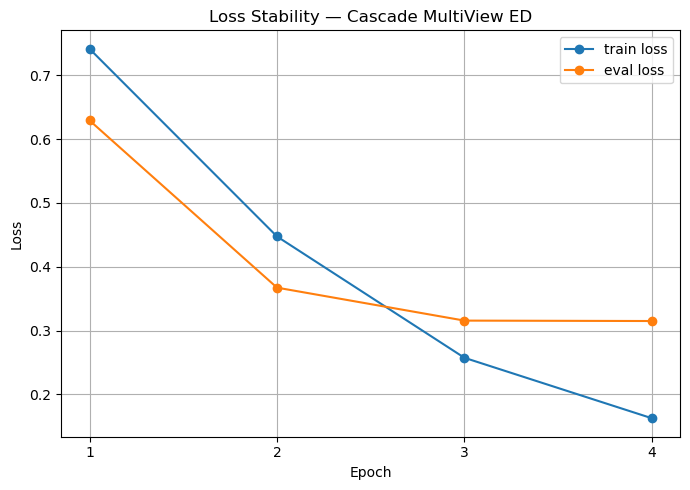

In [10]:
def plot_loss_stability_epochwise(ckpt_dir, title="Cascade Model"):
    state_path = os.path.join(ckpt_dir, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    df = pd.DataFrame(state["log_history"])

    if "epoch" not in df.columns:
        print("No 'epoch' in log_history")
        return

    df["epoch"] = df["epoch"].ffill()
    max_epoch = int(np.floor(df["epoch"].max()))
    epochs = list(range(1, max_epoch + 1))

    train_means, eval_means = [], []
    for e in epochs:
        tr = df[(df["epoch"] > e - 1) & (df["epoch"] <= e) & (df["loss"].notna())]
        ev = df[(df["epoch"] > e - 1) & (df["epoch"] <= e) & (df["eval_loss"].notna())]

        train_means.append(tr["loss"].mean())
        eval_means.append(ev["eval_loss"].mean())

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train_means, marker="o", label="train loss")
    plt.plot(epochs, eval_means, marker="o", label="eval loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Stability — {title}")
    plt.grid(True)
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_loss_stability_epochwise(latest_ckpt, title="Cascade MultiView ED")